In [22]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from irf.ensemble import wrf
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

# Compare different methods in terms of feature selection using simulated data

### load data

In [23]:
X_train = np.loadtxt('../intermediate/02_enhancer/X_train.csv', delimiter=',')
y_train = np.loadtxt('../intermediate/02_enhancer/y_train.csv', delimiter=',')
X_test = np.loadtxt('../intermediate/02_enhancer/X_test.csv', delimiter=',')
y_test = np.loadtxt('../intermediate/02_enhancer/y_test.csv', delimiter=',')
n, m = X_train.shape
names = np.arange(m)

In [24]:
def sigmoid(x):
    x *= 1
    return np.exp(x) / (np.exp(x) + np.exp(-x))
def permute(X):
    tmp = X.copy()
    for j in range(X.shape[1]):
        tmp[:, j] = np.random.permutation(sp.stats.rankdata(tmp[:, j]))
        maximum = max(tmp[:, j])
        tmp[:, j] = tmp[:, j] / maximum - .5
    return tmp
def rankdata(X):
    tmp = X.copy()
    for j in range(X.shape[1]):
        #tmp[:, j] = np.random.permutation(sp.stats.rankdata(tmp[:, j]))
        maximum = max(tmp[:, j])
        tmp[:, j] = tmp[:, j] / maximum - .5
    return tmp
def f(X, noisy_features):
    probs = sigmoid(np.mean(X[:, noisy_features == 0], 1) )
    return np.array([np.random.choice([0, 1], 1, p=[1 - prob, prob]) for prob in probs]).flatten()

In [25]:
n_features = X_train.shape[1]
X_train = permute(X_train)
X_test = permute(X_test)
n, m = X_train.shape
names = np.arange(m)
noisy_features = np.ones((n_features, ), dtype=int)
noisy_features[np.random.choice(range(n_features), 5, replace=False)] = 0
y_train = f(X_train, noisy_features)
y_test = f(X_test, noisy_features)

### save intermediate

In [27]:
np.savetxt('../intermediate/02_enhancer/permuted1_X_train.csv', X_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_y_train.csv', y_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_X_test.csv', X_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_y_test.csv', y_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer/permuted1_noisy_features.csv', noisy_features, delimiter=',')

### Train RF

In [789]:
rf = rfc(n_estimators=100, max_features=8, max_depth=100)
rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [790]:
print('accuracy of RF is {0:.3f}'.format(accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))))

accuracy of RF is 0.528


- Plot feature importance

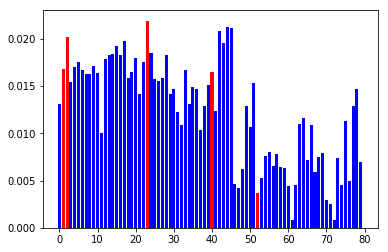

In [791]:
noisy_features = np.array([int(x) for x in noisy_features])
colors = np.array(['red', 'blue'])[noisy_features]
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp, color = colors)
plt.show()

### prune features based on their importance measures

- classic gini importance

     - plot the gini importance

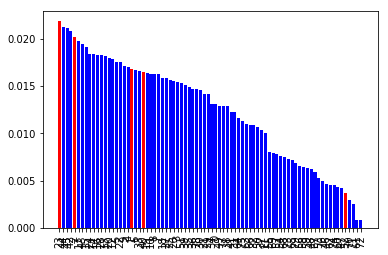

In [792]:
ix = np.argsort(gini_imp * -1)
plt.bar(x = list(range(m)), height = gini_imp[ix], color = colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [793]:
y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()

In [794]:
debiased_fi_mean, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False)

    - plot debiased gini importance

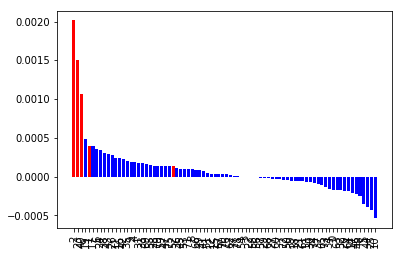

In [795]:
debiased_imp = debiased_fi_mean
ix = np.argsort(debiased_imp * -1)
plt.bar(x = list(range(m)), height = debiased_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- MDA

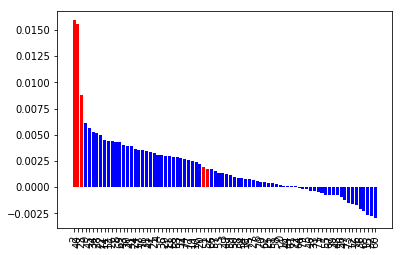

In [796]:
MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=10)
#MDA_imp[MDA_imp < 0] = 0
ix = np.argsort(MDA_imp * -1)
plt.bar(x = list(range(m)), height = MDA_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- tree SHAP

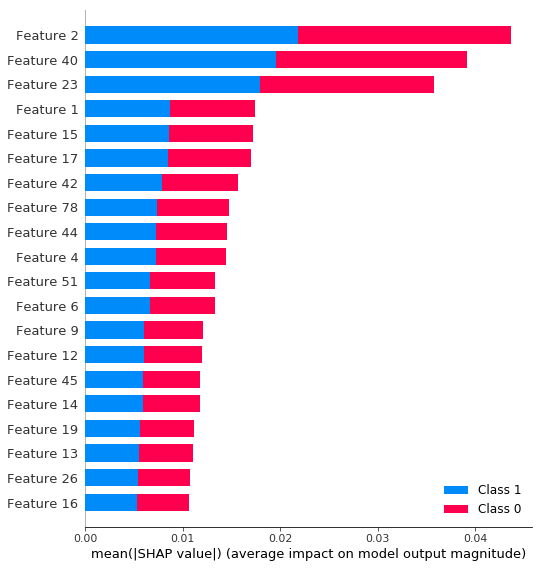

In [797]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

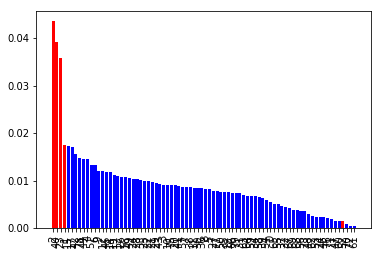

In [798]:
shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
ix = np.argsort(shap_imp * -1)
plt.bar(x = list(range(m)), height = shap_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

### Comparison

In [799]:
debiased_imp[debiased_imp < 0] = 0
MDA_imp[MDA_imp < 0] = 0

In [800]:
roc_auc_score(noisy_features, - debiased_imp)

0.9386666666666666

In [801]:
roc_auc_score(noisy_features, - gini_imp)

0.7066666666666667

In [802]:
roc_auc_score(noisy_features, - shap_imp)

0.808

In [803]:
roc_auc_score(noisy_features, - MDA_imp)

0.8346666666666667

<hr />

### summary of the results from .py file

In [4]:
tmp = np.load('../intermediate/02_simulation_results.npz')
debiased, gini, shap, mda = [tmp[x] for x in list(tmp)]

In [20]:
out = np.array([debiased, shap, mda, gini]).T

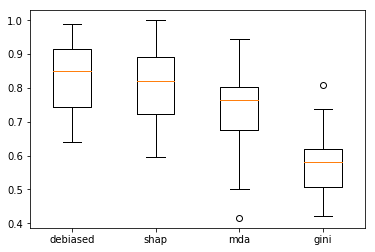

In [21]:
plt.boxplot(out)
plt.xticks(list(range(1, 5)), ['debiased', 'shap', 'mda', 'gini'])
plt.show()